# 0. Data Importing from kaggle

In [1]:
import os
from tqdm.notebook import tqdm
for dirname, _, filenames in tqdm(os.walk('/kaggle/input')):
    for filename in filenames:
        os.path.join(dirname, filename)
#         print(os.path.join(dirname, filename))

0it [00:00, ?it/s]

# Limiting GPU usage

In [2]:
# limit memory to prevent data leak
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    del logical_gpus,gpus
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


2 Physical GPUs, 2 Logical GPUs


# 1. Importing modules

In [3]:
import numpy as np
import pandas as pd
import json
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
train_files = glob("../input/quickdraw-doodle-recognition/train_simplified/*.csv")

# calculating data size per category
rows = 200000
# rows = 10000
rows = rows - (rows % 340)
cat_size = rows // 340
print(cat_size)
gc.collect()

588


56

# 2. Image Preprocessing 
1. converting data in text json to an image 
2. normalizing the image size
3. normalizing the image pixels


In [4]:
from PIL import Image, ImageDraw
from dask import bag
def drawStrokes(matrixOfStrokes):
    image = Image.new("RGB", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in json.loads(matrixOfStrokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    return np.array(image.resize((32,32)))/255.

In [5]:
from tqdm.notebook import tqdm
drawingArray = np.zeros((rows,32,32,3))
categories = pd.Series([None] * rows)
i = 0
for f in tqdm(train_files):
    for df in pd.read_csv(f, index_col="key_id", chunksize=1000, nrows=cat_size):
        df = df.drop(['countrycode','timestamp','recognized'],axis=1)
        imagebag = bag.from_sequence(df.drawing.values).map(drawStrokes)
        imagebag = np.array(imagebag.compute())
        categories[i:(i + imagebag.shape[0])] = df["word"].replace("\s+", "_", regex=True)
        drawingArray[i:(i + imagebag.shape[0])] = imagebag
        i += imagebag.shape[0]


  0%|          | 0/340 [00:00<?, ?it/s]

In [6]:
gc.collect()

39

In [7]:
categories.value_counts()

traffic_light    588
umbrella         588
house            588
trombone         588
paper_clip       588
                ... 
rain             588
rabbit           588
lantern          588
toaster          588
fish             588
Length: 340, dtype: int64

# 3. Train Test split

In [8]:

from sklearn.model_selection import train_test_split
indecator = pd.get_dummies(categories)
tr_x,tst_x,tr_indecator,tst_indecator = train_test_split(drawingArray, indecator, test_size=0.25,random_state=0,stratify=indecator)


In [9]:
itr = 0
for df in tr_indecator:
    print(f"{df} : {tr_indecator[df].value_counts()[1]}")
    if itr == 5:
        break
    else:
        itr+= 1

The_Eiffel_Tower : 441
The_Great_Wall_of_China : 441
The_Mona_Lisa : 441
airplane : 441
alarm_clock : 441
ambulance : 441


In [10]:
itr = 0
for df in tst_indecator:
    try:
        print(f"{df} : {tst_indecator[df].value_counts()[1]}")
    except:
        print(f"{df} : 0")
        
    if itr == 5:
        break
    else:
        itr+= 1

The_Eiffel_Tower : 147
The_Great_Wall_of_China : 147
The_Mona_Lisa : 147
airplane : 147
alarm_clock : 147
ambulance : 147


In [11]:
del drawingArray,categories
gc.collect()

63

# 4. Creating Deep learning model

In [12]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam

filepath = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor="val_loss", 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint]

In [13]:
gc.collect()

42

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *


strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(Conv2D(128,kernel_size=(5,5),padding="same",activation="relu",input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    

    model.add(Conv2D(128, kernel_size=(3,3),activation="relu", strides=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3,3),activation="relu", strides=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(512,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(340,activation="softmax"))

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0

In [17]:
gc.collect()

473

# 5. Training Deep learning model  

RUN 1

Epoch 1/100


2023-03-23 06:50:41.282734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1172/1172 [==============================] - 59s 33ms/step - loss: 4.0293 - accuracy: 0.1830 - val_loss: 4.0359 - val_accuracy: 0.1767
Epoch 2/100
1172/1172 [==============================] - 33s 29ms/step - loss: 3.0467 - accuracy: 0.3167 - val_loss: 4.5984 - val_accuracy: 0.1496
Epoch 3/100
1172/1172 [==============================] - 32s 27ms/step - loss: 2.7679 - accuracy: 0.3652 - val_loss: 6.0920 - val_accuracy: 0.0561
Epoch 4/100
1172/1172 [==============================] - 33s 29ms/step - loss: 2.6065 - accuracy: 0.3935 - val_loss: 3.7935 - val_accuracy: 0.1965
Epoch 5/100
1172/1172 [==============================] - 32s 27ms/step - loss: 2.4971 - accuracy: 0.4133 - val_loss: 5.8715 - val_accuracy: 0.0983
Epoch 6/100
1172/1172 [==============================] - 32s 27ms/step - loss: 2.4169 - accuracy: 0.4296 - val_loss: 2.4720 - val_accuracy: 0.4267
Epoch 7/100
1172/1172 [==============================] - 32s 27ms/step - loss: 2.3471 - accuracy: 0.4424 - val_loss: 4.1661 - val_

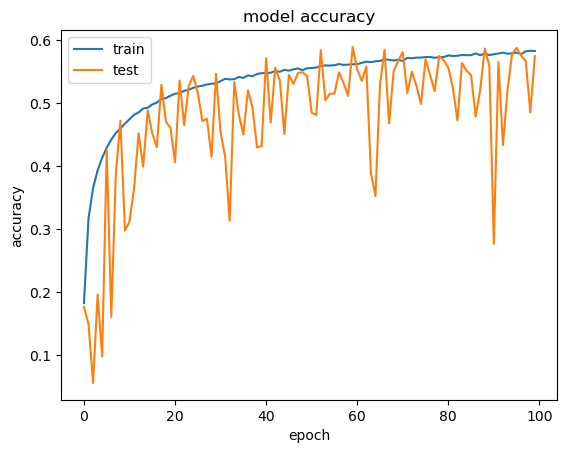

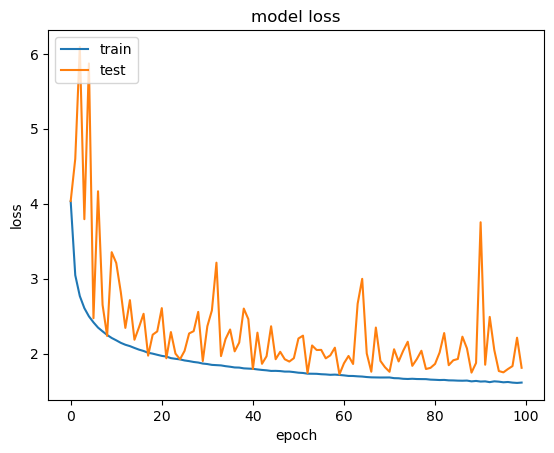

In [18]:
# history = model.fit(tr_x, tr_indecator,batch_size=200,epochs=100
#           ,validation_data=(tst_x,tst_indecator))

history = model.fit(tr_x, tr_indecator,batch_size=128,epochs=100
          ,validation_data=(tst_x,tst_indecator),callbacks=callbacks)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# 6. Saving model 

In [19]:
from tensorflow.keras.models import save_model
save_model(model,"CNN.h5")

In [20]:
# RUN 1
# Epoch 30/30
# 600/600 [==============================] - 18s 30ms/step - loss: 2.2876 - accuracy: 0.4391 - val_loss: 2.1696 - val_accuracy: 0.4867

# RUN 2


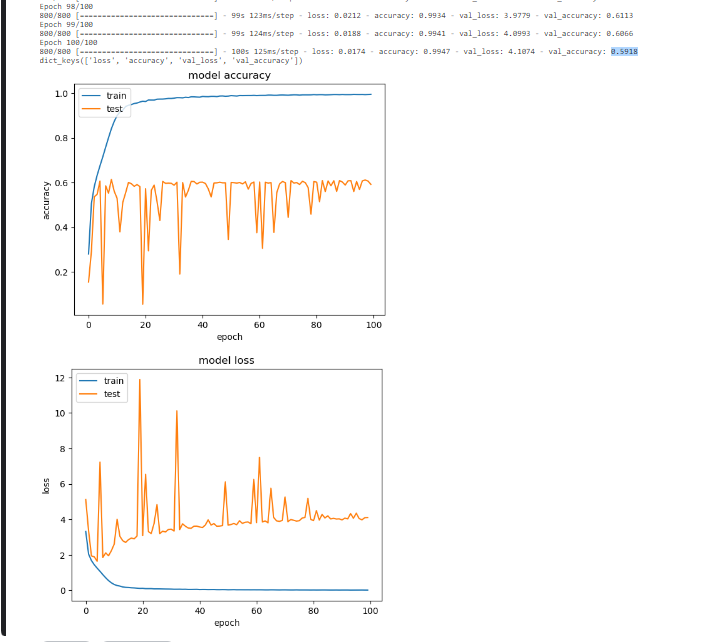

RUN 3


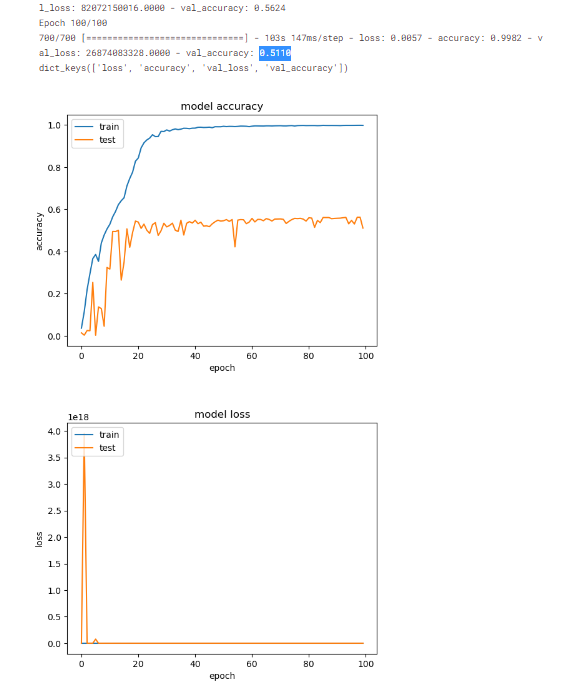

RUN 4


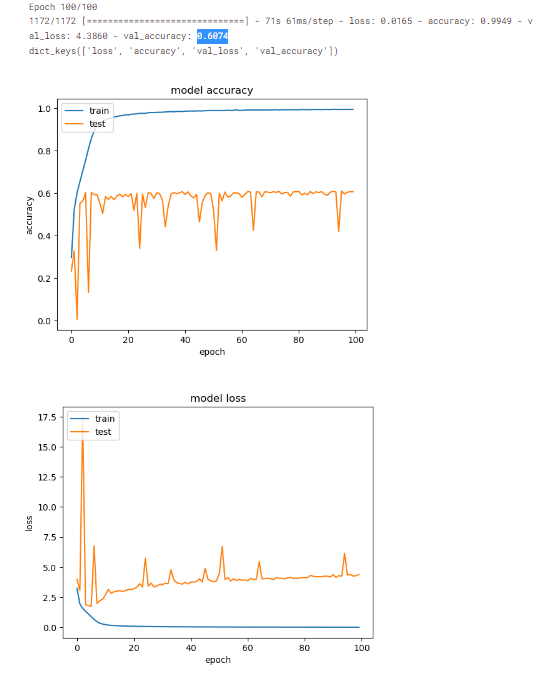